# Analysis Demo

This notebook corresponds to the main analyses descriped in the paper "Neuromodulatory systems partially account for the topography of cortical networks of learning under uncertainty" 

It demonstrates how to use the provided code to easily scan new data for neuromodulatory involvement and eveluate the contribution of individual receptors 

In [ ]:
#load packages
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting, datasets, image
from nilearn import surface
from nilearn.glm.second_level import SecondLevelModel
from config.loader_demo import load_config
from utils.main_funcs import nii_to_cortical_voxel_array
from analysis.regression_cv_with_spintest import prepare_spins, run_reg_cv_with_spin
from analysis.variance_explained import run_comp_null, run_predict_from_beta, run_group_ratio_summary
from analysis.receptor_effect_map_relationship  import run_dominance_analysis, load_dominance_data, aggregate_dominance, plot_dominance_bars, plot_legend_dominance_bars


## Prerequisits

- environemnt set up as specified in the environnment.txt file in the corresponding github reposetory
- the code works with volumetric beta (effect) maps
- The data should be normalized MNI space and should be or otherwise will be resampled to the 2mm resolution, as this corresponds to the resolution of the receptor/tranporter densitieies provided
- the code assumes the fMRI beta (effect) map's names to be in the format: TaskName_Variable_effect_size_map.nii.gz


## Set paths and parameteres

Here we reanalyse the data from study 1, as reported in the manuscript, but this can be changed to any other fMRI data in the right format by adapting the paths in config.demo_config
The strucure of the code allows for the comparison of multiple different variables at the same time by changing the parameter latent_vars

Note: due to copyright reasons we are here using only the recpetors provided by Hansen et al. (2022)


In [3]:
params, paths, rec = load_config('study_1', return_what='all')


## Preprocessing: create effect arrays for further analysis

Currently the analysis only runs on cortical data, since PET radioligand sensitivity differs markedly between cortical and subcortical structures 
The data is therefore masked and saved as an voxel array for future analysis.


In [3]:
# Find all .nii.gz files
all_nii = glob(os.path.join(paths.beta_dir, "*.nii.gz"))

# Group files by latent variable
matching_nii_sorted = {
    lv: [
        f for f in all_nii
        if lv in os.path.basename(f)
    ]
    for lv in params.latent_vars
}

# Optional sanity check
for lv, files in matching_nii_sorted.items():
    print(f"{lv}: {len(files)} matching files")


confidence: 26 matching files
surprise: 26 matching files


In [4]:
# Loop through and process
for latent_var, matching_nii in matching_nii_sorted.items():

    for nii_file in matching_nii:

        array, mask = nii_to_cortical_voxel_array(os.path.join(paths.beta_dir, nii_file))

        base = os.path.basename(nii_file).replace("_map.nii.gz", "")
        out_path = os.path.join(paths.beta_dir, f"{base}.pickle")
        with open(out_path, "wb") as f:
                pickle.dump(array, f)

## plot group level effect maps

<Figure size 2400x1200 with 0 Axes>

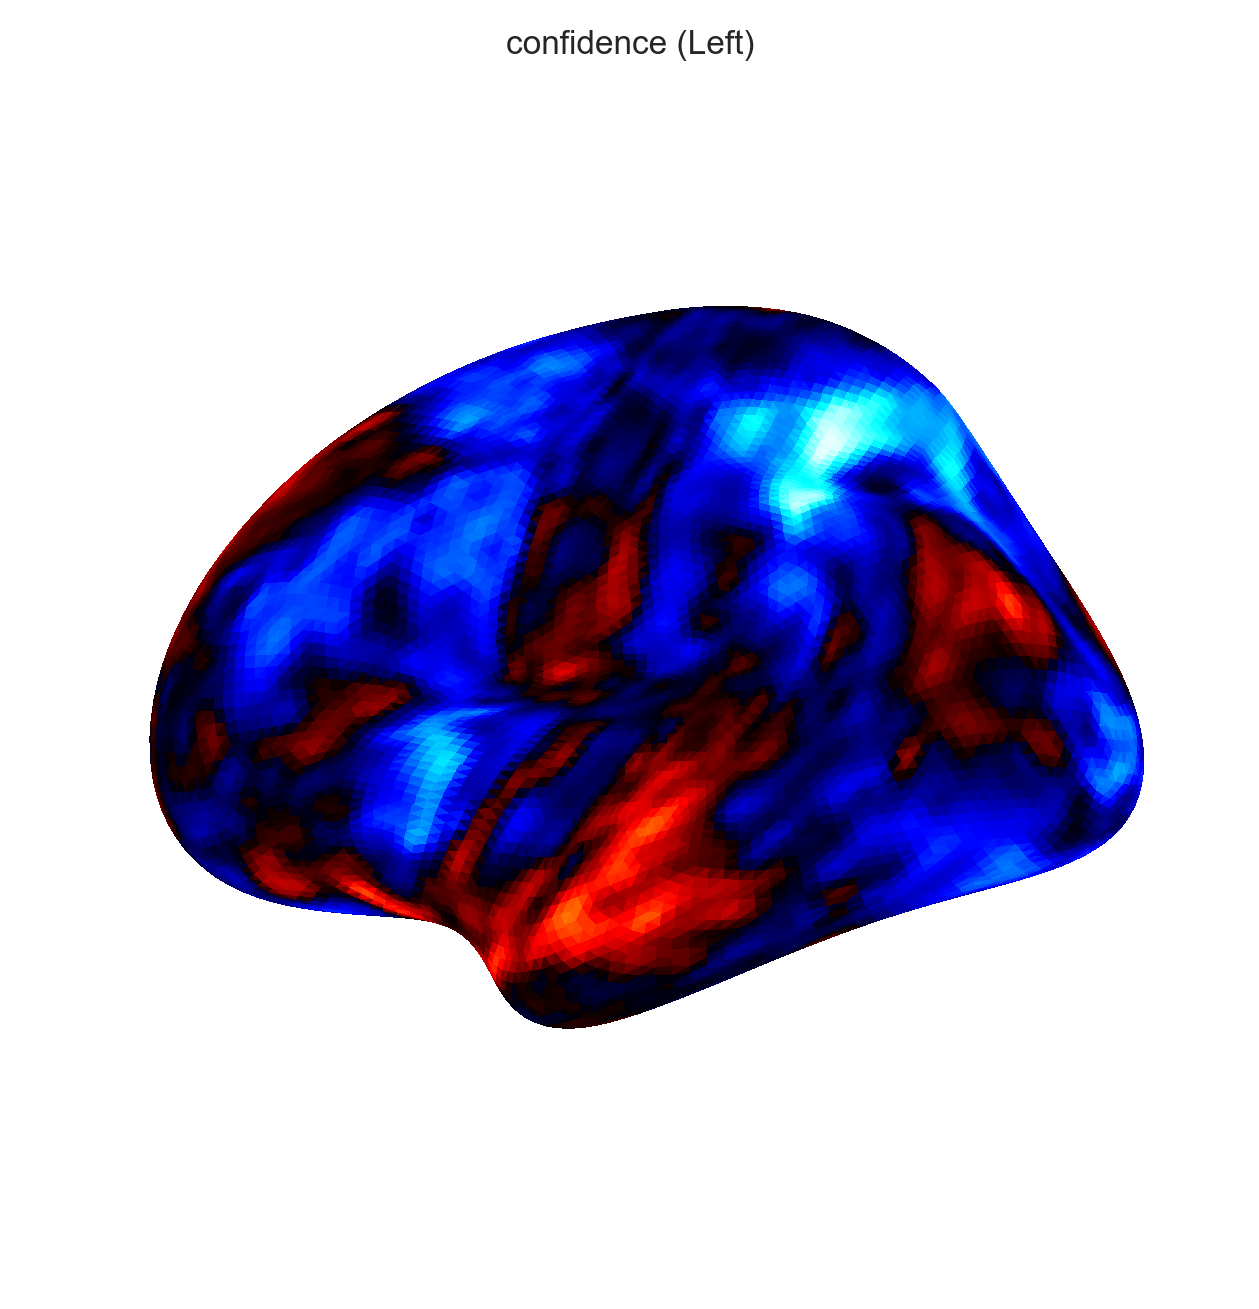

<Figure size 2400x1200 with 0 Axes>

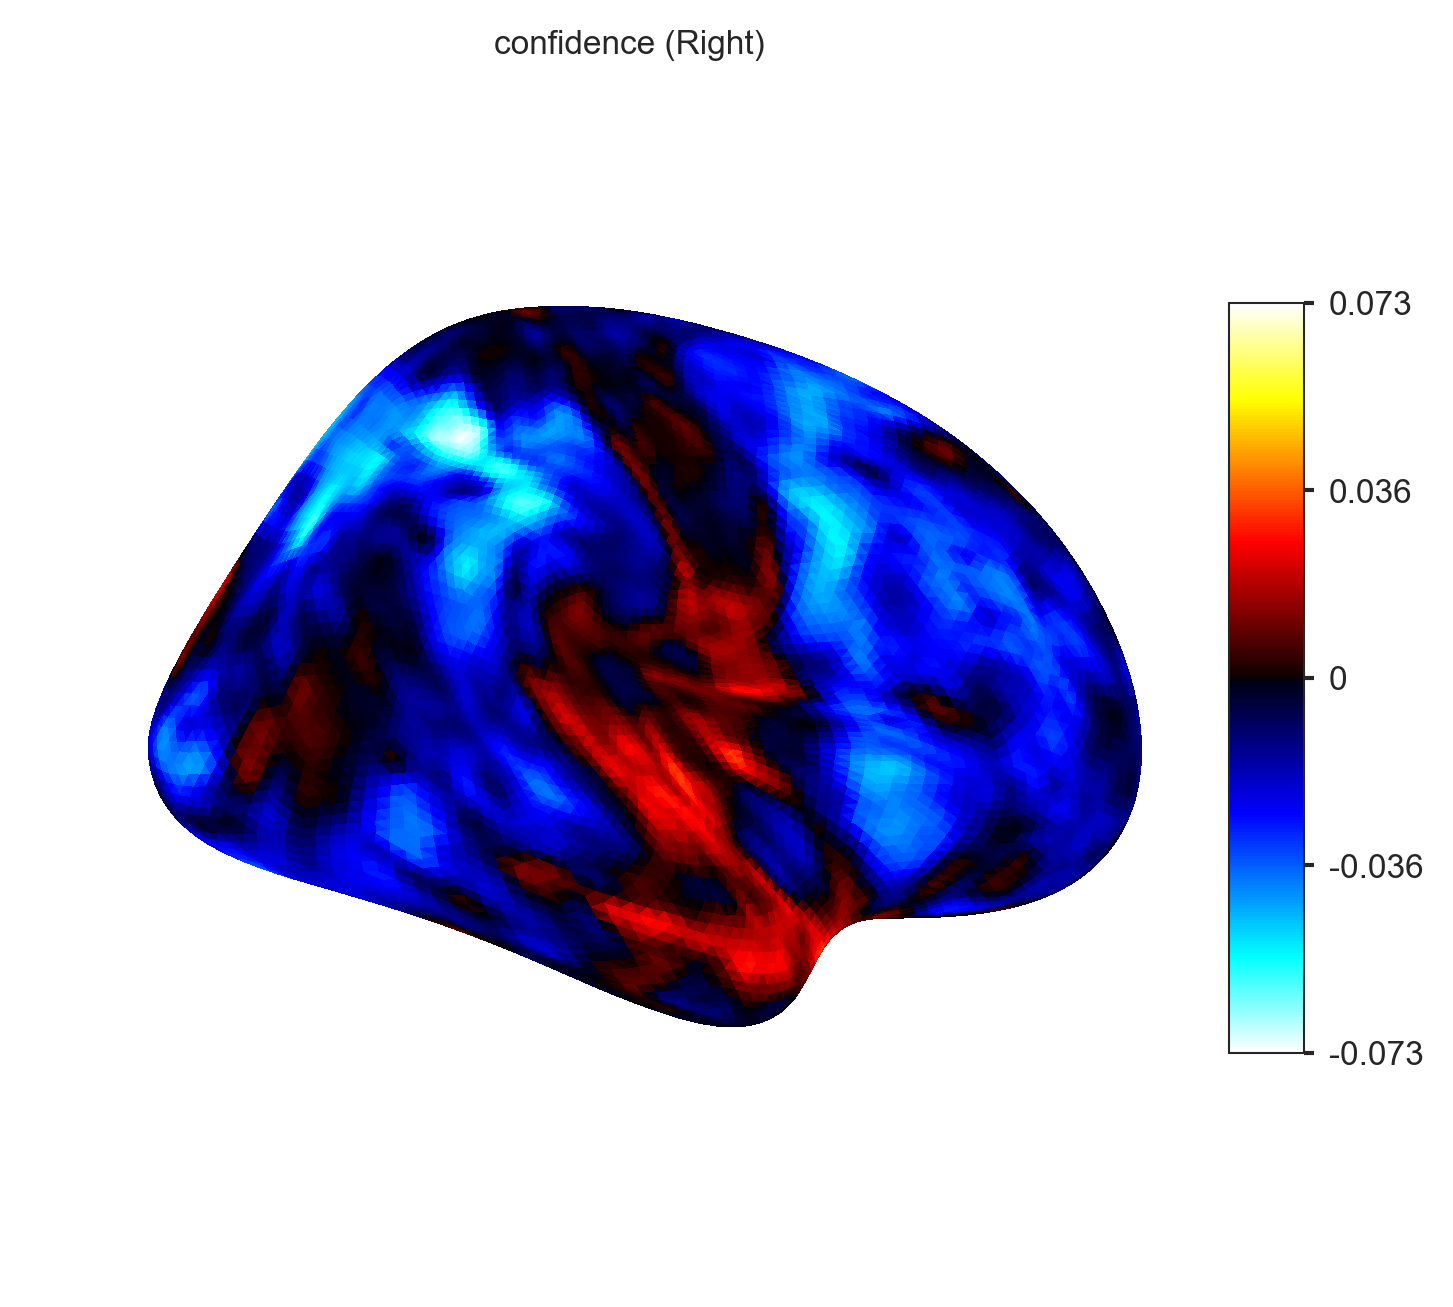

<Figure size 2400x1200 with 0 Axes>

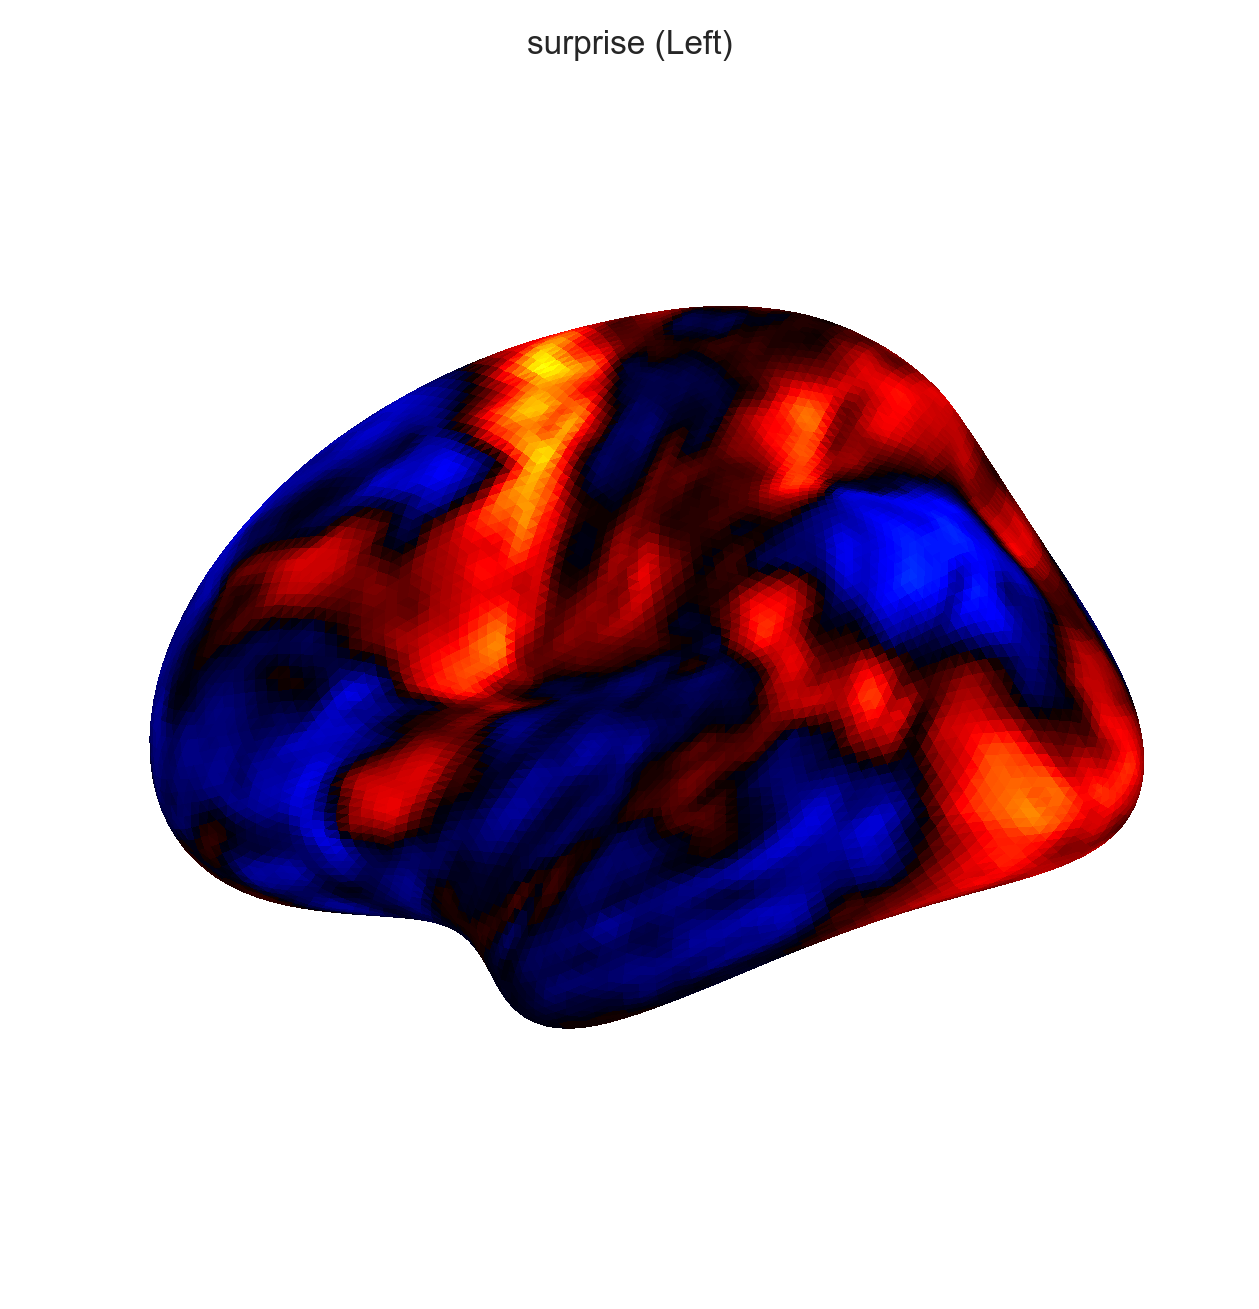

<Figure size 2400x1200 with 0 Axes>

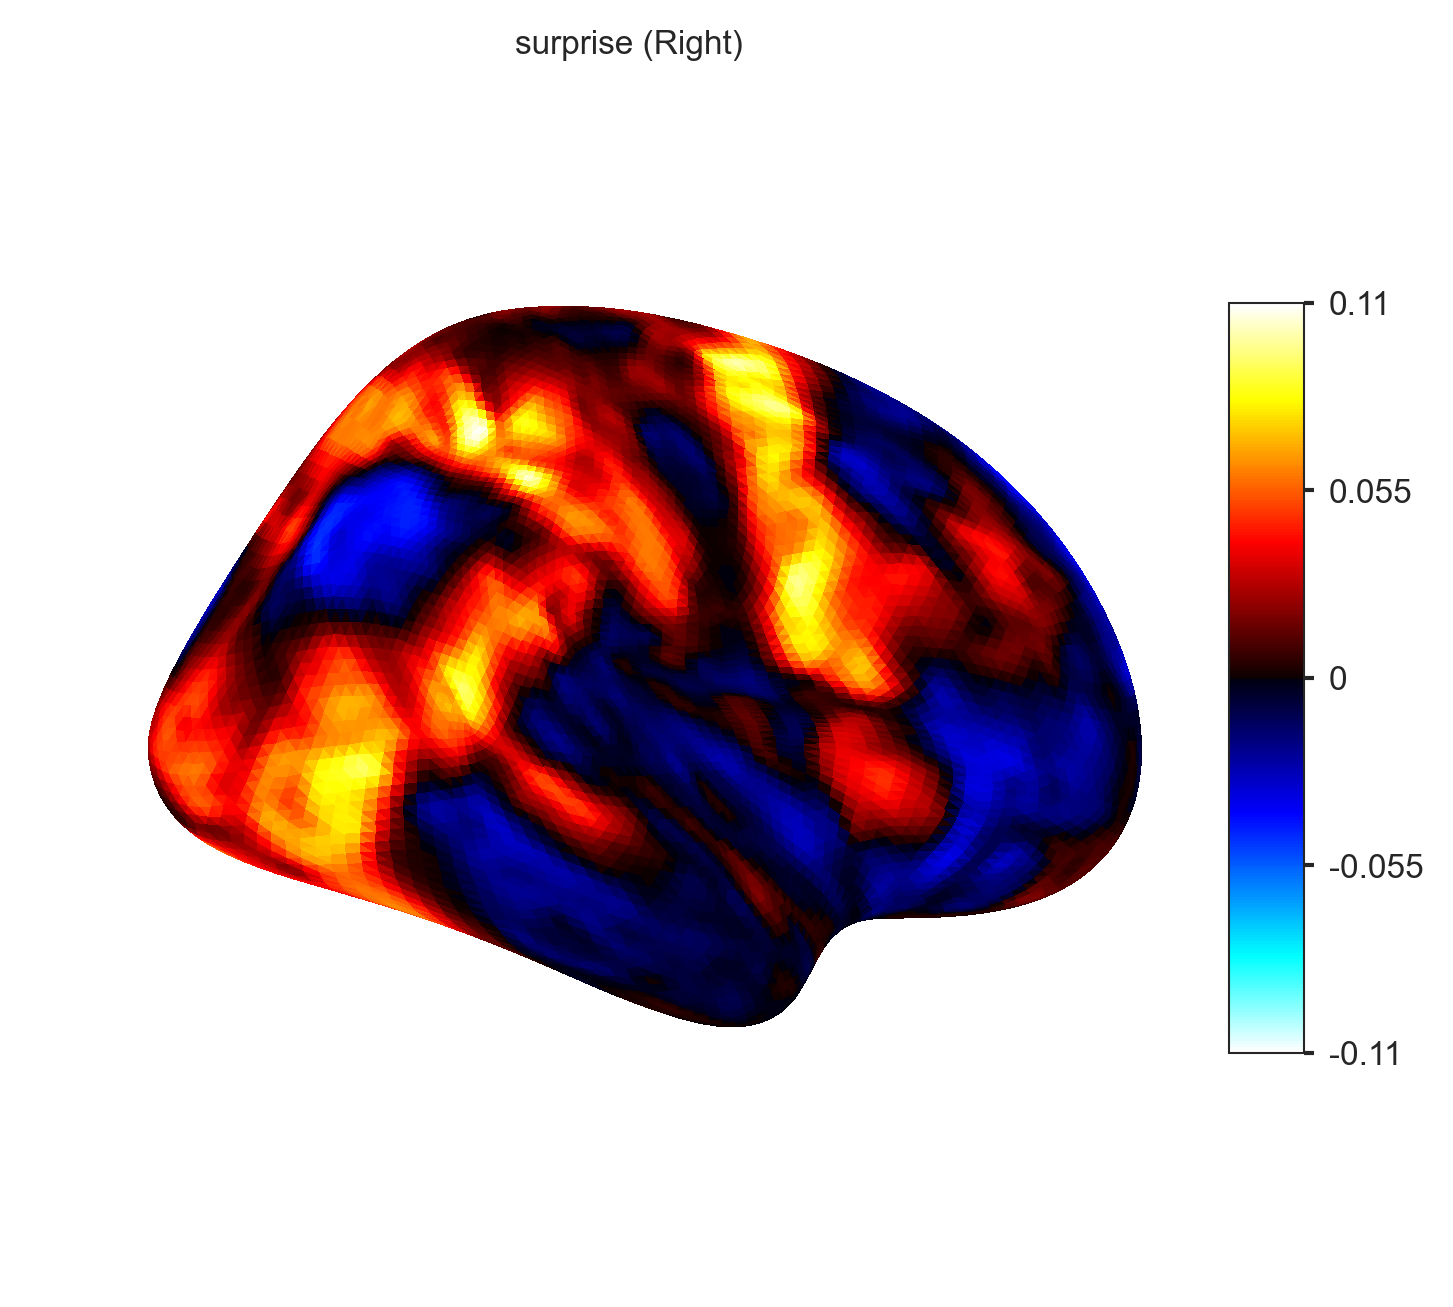

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()

for latent_var, matching_nii in matching_nii_sorted.items():

    # Design matrix
    design_matrix = pd.DataFrame(
        {'intercept': [1] * len(matching_nii)}
    )

    # Fit second-level model
    second_level_model = SecondLevelModel().fit(
        matching_nii,
        design_matrix=design_matrix
    )

    # Compute group-level effect 
    effect_map = second_level_model.compute_contrast(
        'intercept',
        output_type='effect_size'
    )

    # Project to surface 
    texture_left = surface.vol_to_surf(effect_map, fsaverage.pial_left)
    texture_right = surface.vol_to_surf(effect_map, fsaverage.pial_right)

    # Plot 
    plotting.plot_surf_stat_map(
        fsaverage.infl_left,
        texture_left,
        hemi='left',
        view='lateral',
        colorbar=False,
        title=f'{latent_var} (Left)',
    )
    plotting.plot_surf_stat_map(
        fsaverage.infl_right,
        texture_right,
        hemi='right',
        view='lateral',
        colorbar=True,
        title=f'{latent_var} (Right)',
    )

    plotting.show()


## Run regression and null model for further analysis 

Runs a leave-one-subject-out cross validated rgression between effect map and all available receptor and transporter maps

ATTENTION: the cross-validation runs few minutes, especially when combined with the null spins 

For the demo, this step can be skiped as the results are provided in the results/regression folder 

In [ ]:
spins = prepare_spins(paths, rec, n_spins=1000)

run_reg_cv_with_spin(params, paths, rec, spins, output_dir=os.path.join(paths.results_dir, 'regressions'), run_spin = True)

--- CV for EncodeProb and confidence ---
--- CV for subject 0 out of 26 ---
--- CV for subject 1 out of 26 ---
--- CV for subject 2 out of 26 ---
--- CV for subject 3 out of 26 ---
--- CV for subject 4 out of 26 ---
--- CV for subject 5 out of 26 ---
--- CV for subject 6 out of 26 ---
--- CV for subject 7 out of 26 ---
--- CV for subject 8 out of 26 ---
--- CV for subject 9 out of 26 ---
--- CV for subject 10 out of 26 ---
--- CV for subject 11 out of 26 ---
--- CV for subject 12 out of 26 ---
--- CV for subject 13 out of 26 ---
--- CV for subject 14 out of 26 ---
--- CV for subject 15 out of 26 ---
--- CV for subject 16 out of 26 ---
--- CV for subject 17 out of 26 ---
--- CV for subject 18 out of 26 ---
--- CV for subject 19 out of 26 ---
--- CV for subject 20 out of 26 ---
--- CV for subject 21 out of 26 ---
--- CV for subject 22 out of 26 ---
--- CV for subject 23 out of 26 ---
--- CV for subject 24 out of 26 ---
--- CV for subject 25 out of 26 ---
--- Spin test for EncodeProb and 

## Variance explained tested for significance

Compares the explained variance prediting the fMRI effect map from true receptor and transporter maps to a null model that uses spatially rotated receptor and tranporter maps

In [6]:
run_comp_null(params, data_dir=os.path.join(paths.results_dir, 'regressions'), to_file=False)

EncodeProb and confidence:
t-value: -2.5569664531092577
p-value: 0.008505375565823097
FDR-corrected p-value: 0.008505375565823097
df: 25

EncodeProb and surprise:
t-value: -2.7408716730897784
p-value: 0.0055743374896903425
FDR-corrected p-value: 0.008505375565823097
df: 25



## Ratio of explained variance
First calculate the maximum explainable variance  by predicting a subjects beta map (effect map) from the mean beta map of the other subjects

In [7]:
run_predict_from_beta(params.tasks, params, paths, os.path.join(paths.results_dir, 'max_variance'), to_file=False)


EncodeProb: maximum variance explained in analysis

confidence: 0.12174548094089215, sem: 0.014758012457847322
surprise: 0.2531966727513533, sem: 0.02351725047166004




Now  calculate the proportion of mean explained variance in the cross validated regression in relationship to the mean max. explainable variance

In [5]:
run_group_ratio_summary(params, data_dir=paths.results_dir, to_file=False)

EncodeProb confidence: 29.3%
EncodeProb surprise: 18.5%


## Evaluate the contribution of individual receptors

### Run dominance analysis

ATTENTION: this step is very computationally demanding. The number of subjects that are run in parallel can be adjusted using num_workers 

For the demo, this step can be skiped as the dominance results for both surprise and confidence are provided in the results/dominance folder

In [ ]:
##uncomment this to run the dominance analysis
run_dominance_analysis(
            params=params,
            paths=paths,
            rec=rec,
            model_type="linear",
            start_at=0,
            num_workers=4,
            output_dir=os.path.join(paths.results_dir, 'dominance') 
        )

### Plot dominance results
Illustrates the contribution of each receptor and transporter to the model fit. 

The percent contribution of each receptor reflects the variables dominance normalized by the full model fit to make contributions comparable across datasets.

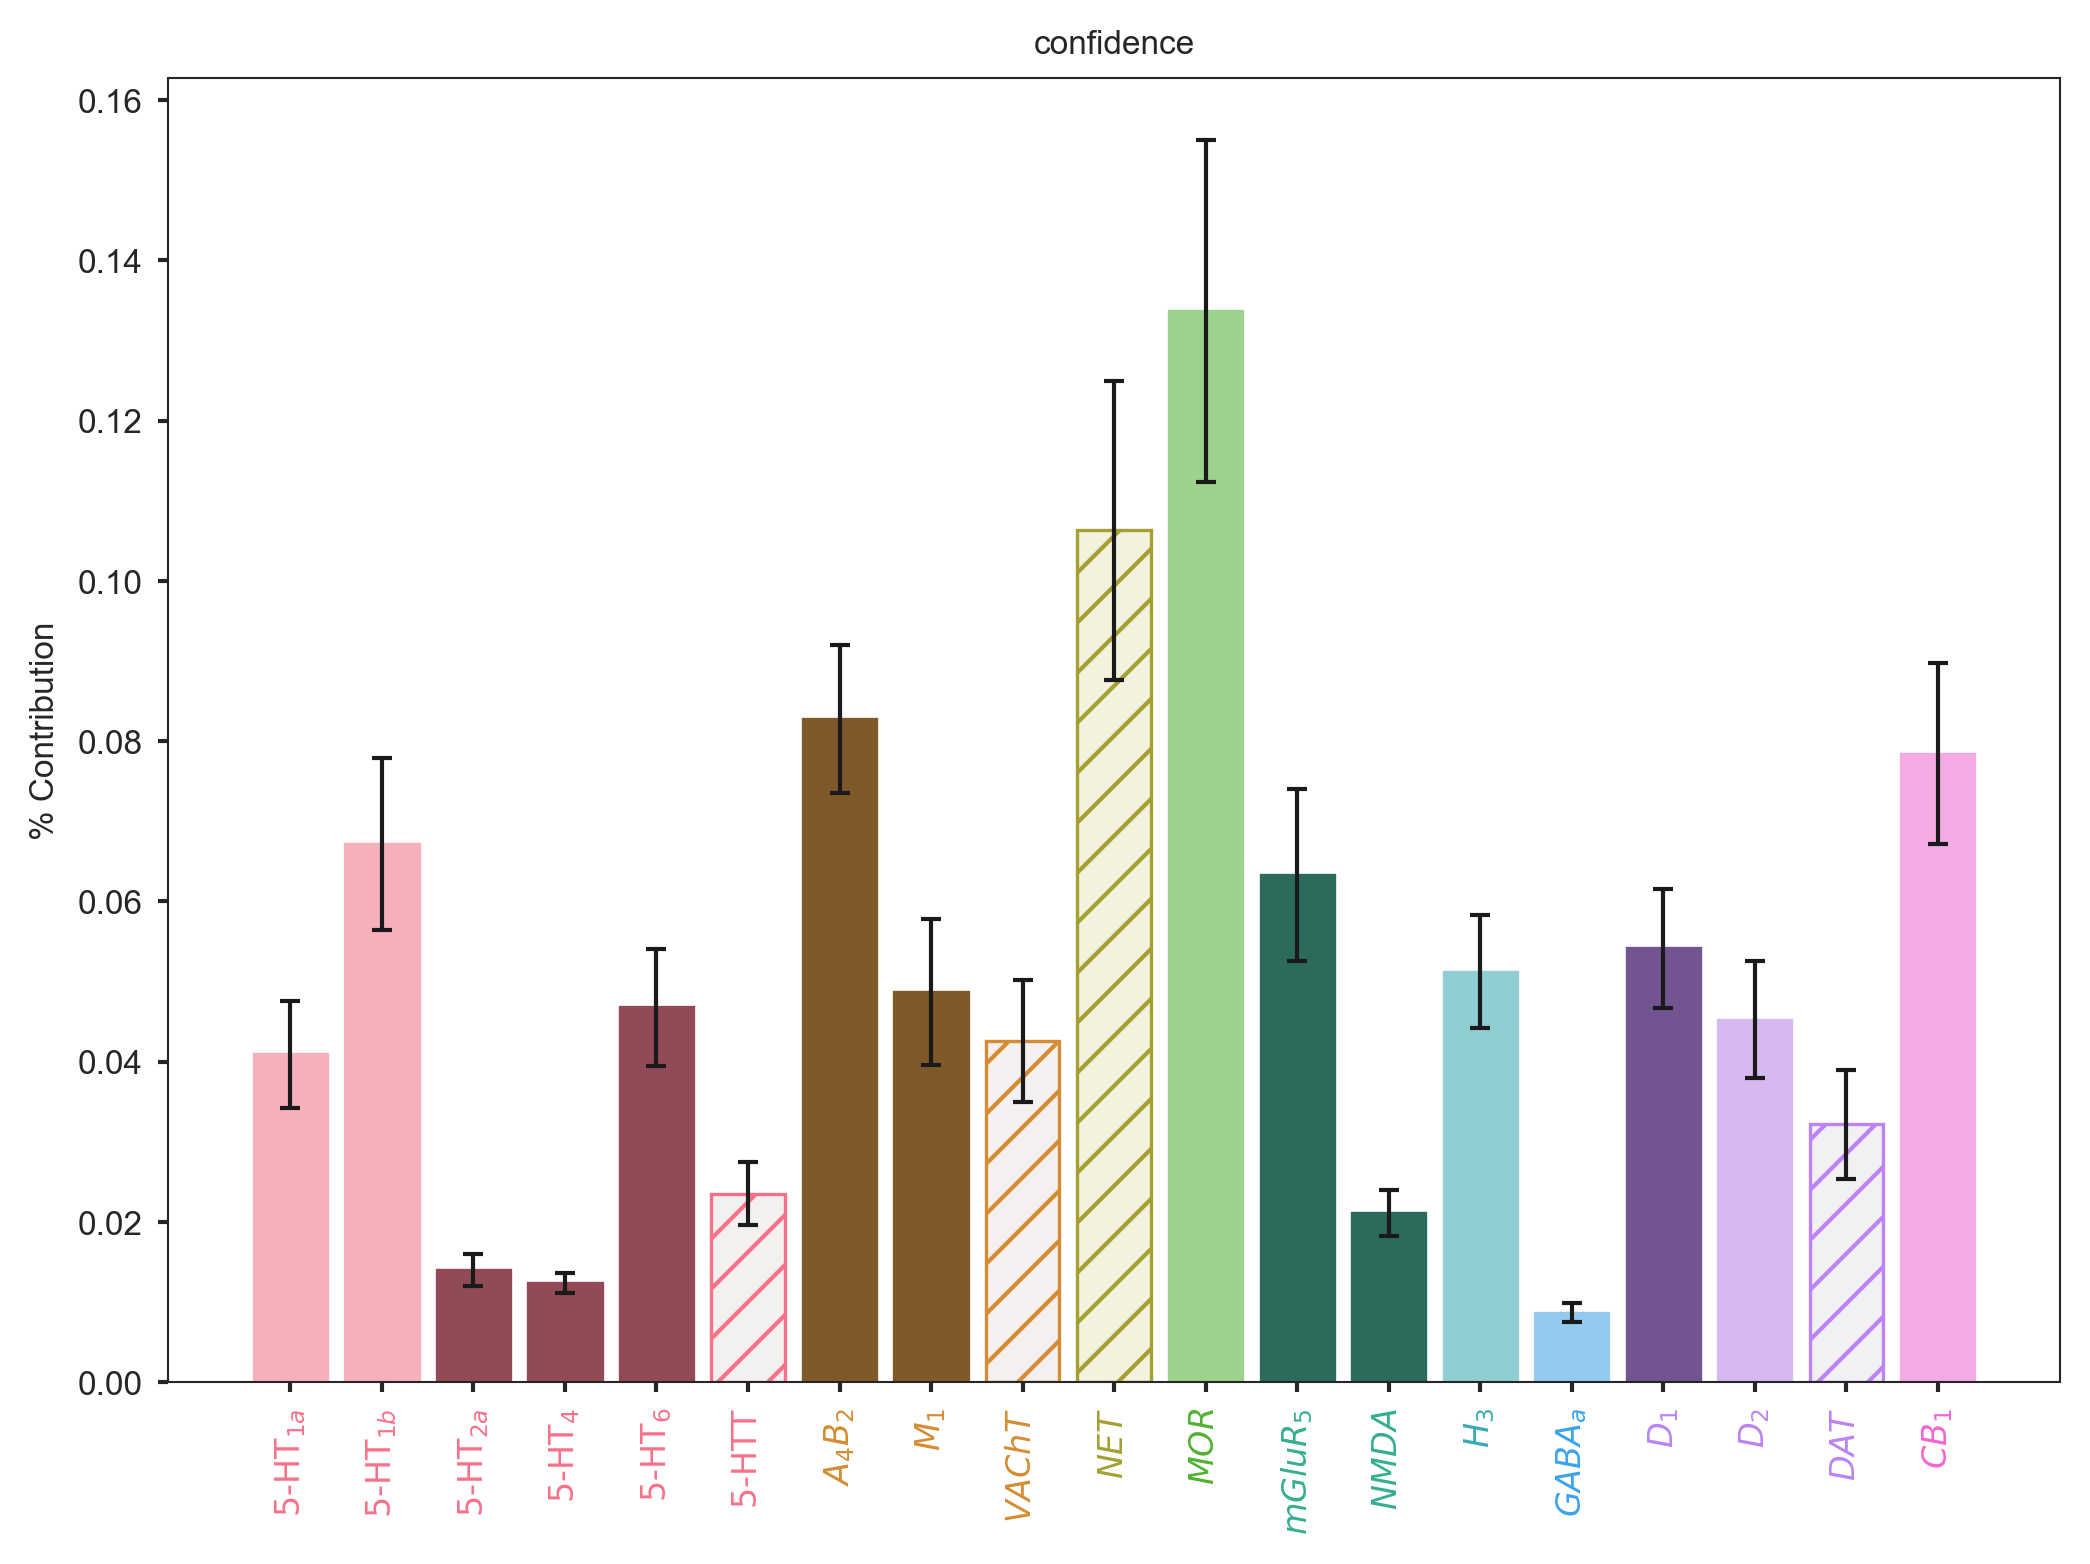

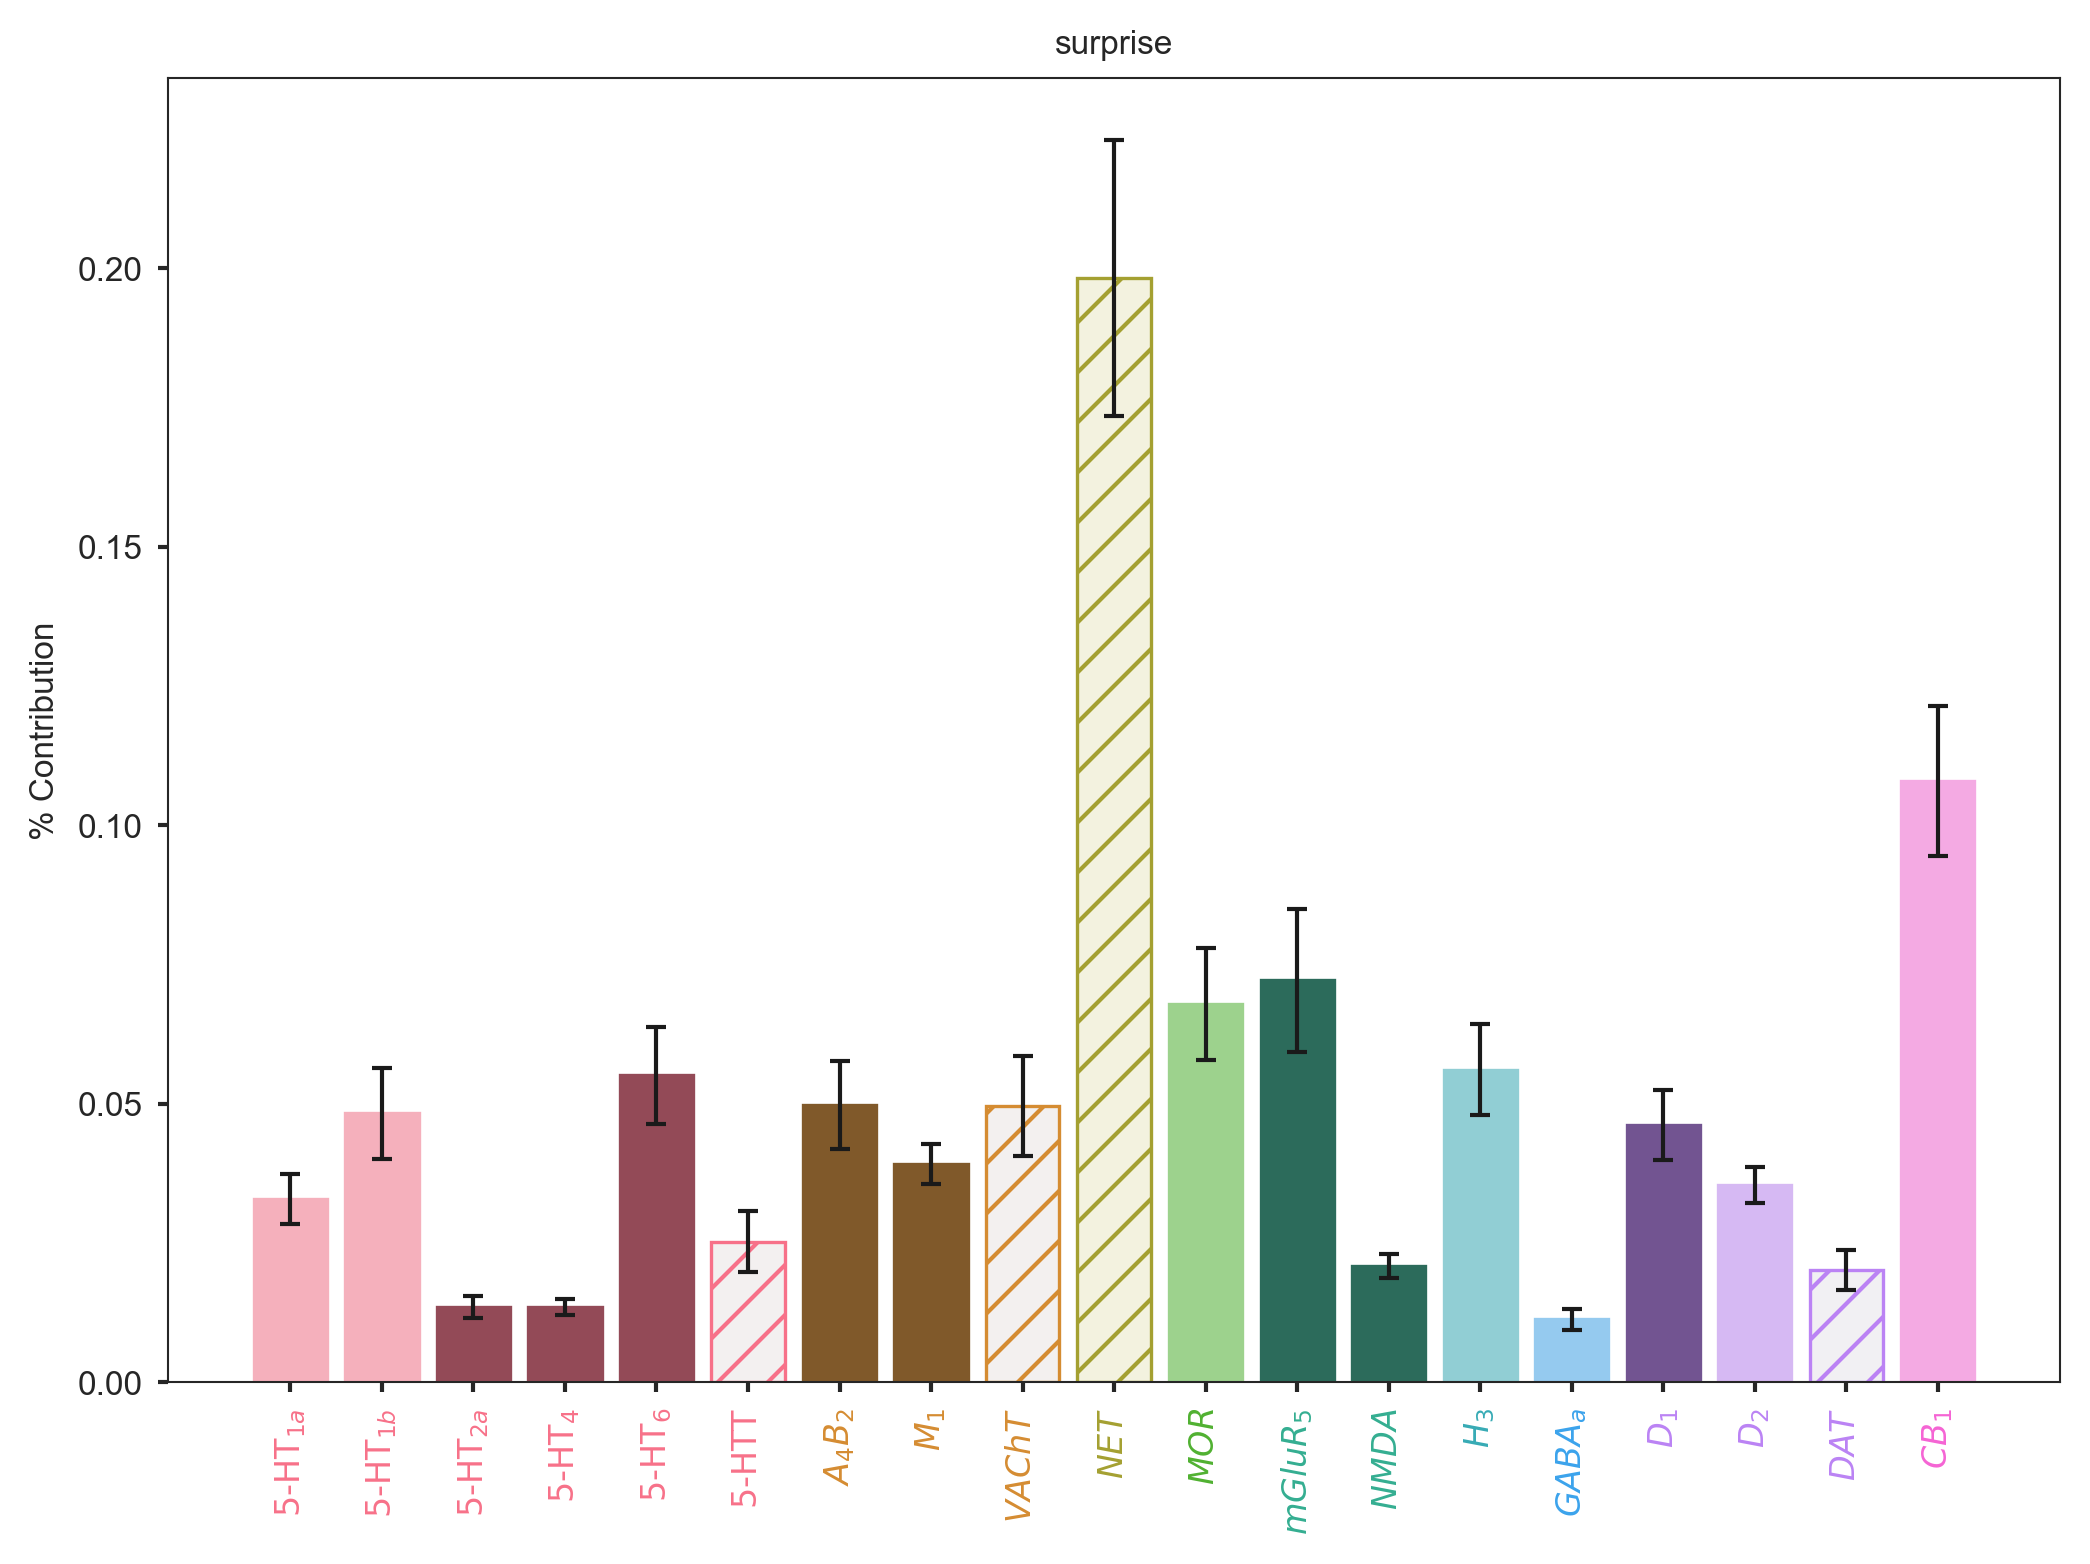

In [4]:
for latent_var in params.latent_vars:
    results = load_dominance_data(params, paths, latent_var, model_type='linear')
    df_combined, _ = aggregate_dominance(results)
    plot_dominance_bars(df_combined, rec.receptor_groups, rec.receptor_class, rec.receptor_label_formatted, title=latent_var)

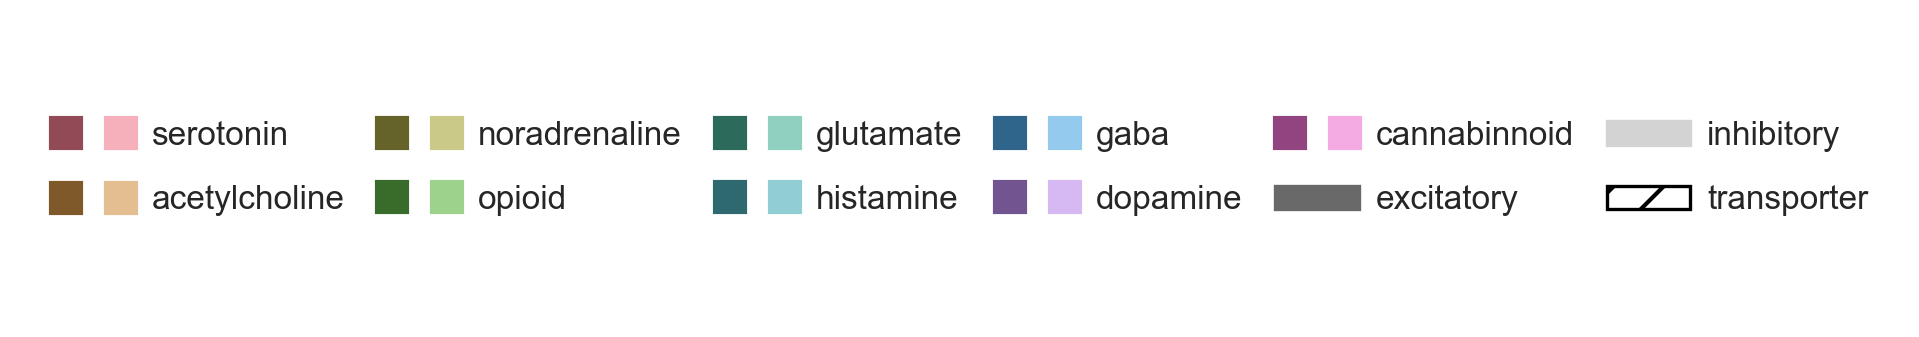

In [16]:
fig = plot_legend_dominance_bars(rec, ncol=6)
